In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.colors import Normalize


from utils.loss import model_loss_mse, model_loss_equation
from utils.model import PINNS_MLP
from utils.format_data import to_csv, merge_traindata
from utils.visualization import visualize_unsteady_time

''' 
Save model :
    torch.save(model.state_dict(), 'model.pth')
    
Load a saved model :
    loaded_model = PINNS_MLP()
    loaded_model.load_state_dict(torch.load('model.pth'))
    loaded_model.eval()
    
Predict with a loaded model :
    Y_pred = loaded_model(X_standardized)
'''

In [2]:
# Data of the same mesh that evolves from t=0.01s to t=5s
folder_names = ["trainset/fluid-domain", "trainset/walls"]

# Transform into .csv files
times = np.arange(0.01, 5.01, 0.01)
to_csv(folder_names, times)

# Note: Takes around 5 minutes to run

In [2]:
def refinement_walls(X, Y, xc, yc, r, d, eps, nb_nodes, time_indices) :
    X_ref = torch.empty(len(X), 3)
    Y_ref = torch.empty(len(X), 3)
    train_range_size = len(time_indices)
    index = 0
    count = 0
    for i in range(nb_nodes) :
        x = X[i,0]; y = X[i,1]
        if (x >= xc-r-d and y >= yc-r-d and y <= yc+r+d) or x <= eps or x >= 1-eps or y <= eps or y >= 0.5-eps :
            indices = [i + k*nb_nodes for k in time_indices]
            X_ref[index:index+train_range_size] = X[indices]
            Y_ref[index:index+train_range_size] = Y[indices]
            index += train_range_size
            count += 1
    
    return X_ref[:index], Y_ref[:index]

In [3]:
times = np.arange(0.01, 5.01, 0.01)

########################################################################
X, Y = merge_traindata(["trainset/fluid-domain"], times)
nb_nodes = int(len(X)/len(times))
train_range_size = 50
time_indices = np.random.randint(0, high=400, size=train_range_size)
train_indices = np.zeros(train_range_size*nb_nodes)
for i in range(train_range_size) :
    train_indices[i*nb_nodes : (i+1)*nb_nodes] = np.arange(time_indices[i]*nb_nodes, (time_indices[i]+1)*nb_nodes)


### Create the dataset on the entire fluid domain ###
#####################################################
X_train = X[train_indices]
Y_train = Y[train_indices]

mean_x = X_train.mean(dim=0)
std_x = X_train.std(dim=0)
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)

X_standardized = (X_train - mean_x)/ std_x
Y_standardized = (Y_train - mean_y)/ std_y

X_standardized.requires_grad_(True)

### Create the dataset near walls only ###
##########################################
X_walls, Y_walls = refinement_walls(X, Y, 0.3, 0.25, 0.025, 0.1, 0.08, nb_nodes, time_indices)
# X_walls, Y_walls = merge_traindata(["trainset/walls"], times)

X_walls_standardized = (X_walls - mean_x)/ std_x
Y_walls_standardized = (Y_walls - mean_y)/ std_y

In [ ]:
print(len(X_standardized))
print(len(X_walls_standardized))

In [4]:
def display_sol(model, X_test, X_test_standardized) :

    Y_test_pred = model(X_test_standardized)
    Y_test_pred = Y_test_pred * std_y + mean_y

    x_test = X_test[:,0]
    y_test = X_test[:,1]

    prediction = Y_test_pred[:,1]

    z_min = -0.2738304
    z_max = 1.5554267

    norm = Normalize(vmin=z_min, vmax=z_max)

    plt.figure(figsize=(5, 3))
    plt.scatter(x_test.detach().numpy(), y_test.detach().numpy(), c=prediction.detach().numpy(), cmap='jet', s=5, norm=norm)
    cbar1 = plt.colorbar()
    cbar1.set_label("u")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    plt.show()

In [ ]:
time_index = 300
X_test = X[time_index*nb_nodes:(time_index+1)*nb_nodes]
X_test_standardized = (X_test - mean_x)/ std_x

In [ ]:
# Model first initialized with random weights
model = PINNS_MLP()

N_EPOCH = 1500
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses_bc = np.zeros(N_EPOCH)
losses_pde = np.zeros(N_EPOCH)
alpha = 10

for i in range(N_EPOCH):
        
    tic = time.time()
    optimizer.zero_grad()
    
    loss_pde = model_loss_equation(model, X_standardized, 1e3, 1e-6)
    loss_bc = model_loss_mse(model, X_walls_standardized, Y_walls_standardized)
    
    loss = loss_pde + alpha*loss_bc

    loss.backward()
    optimizer.step()
    tac = time.time()
    
    print(f'ite {i+1}, loss_pde: {loss_pde}, loss_bc: {loss_bc}, time [s]: {tac-tic}', end='\r')
    if (i+1) % 100 == 0:
        print(f'ite {i+1}, loss_pde: {loss_pde}, loss_bc: {loss_bc}, time [s]: {tac-tic}')
        display_sol(model, X_test, X_test_standardized)

    losses_bc[i] = loss_bc.item()
    losses_pde[i] = loss_pde.item()

torch.save(model.state_dict(), './saved_models/model_test.pth')

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(range(N_EPOCH), losses_bc, label='PDE loss')
plt.plot(range(N_EPOCH), losses_pde, label='BC loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(r'Loss vs epoch, $(\alpha) = $' + f'({alpha})')
plt.legend(loc='upper right')

In [ ]:
# Load the saved model built by the train piece of code above
model = PINNS_MLP()
model.load_state_dict(torch.load('./saved_models/model2.pth'))
model.eval()

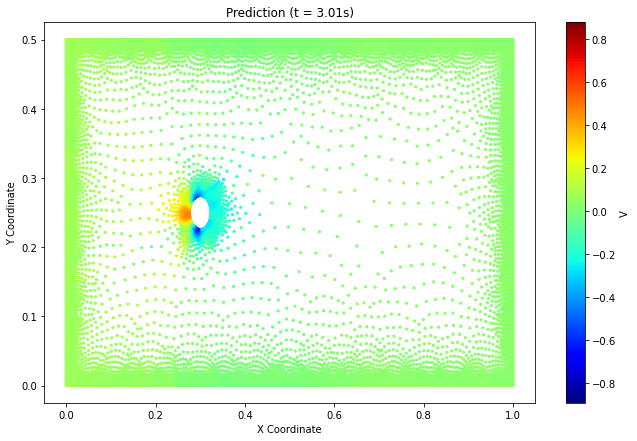

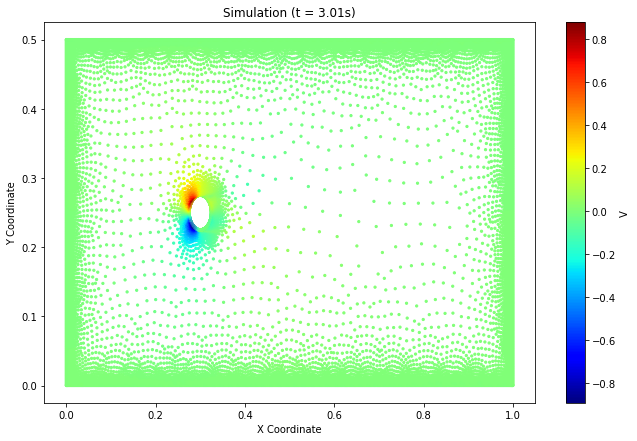

In [18]:
# temporal index, belongs to {0, ..., len(times)-1}
time_index = 300

# index associated to the quantity : pressure -> 0, ux -> 1, uy -> 2
index_quantity = 2

visualize_unsteady_time(model, time_index, index_quantity, X, Y, mean_x, std_x, mean_y, std_y, nb_nodes)